In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import sys
import os 

os.chdir("../")

from einops import rearrange
import einops 
import numpy as np
import torch

from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from typing import List
from torchvision.transforms import Compose, ToTensor, Lambda

# Datasets

In [2]:
dataset = load_dataset("nielsr/CelebA-faces")

CHANNELS = 3
BATCH_SIZE = 64
TIMESTEPS = 1000
UPSCALE_IMAGE_SIZE = 64

device = "cuda" if torch.cuda.is_available() else "cpu"

_dataset_transform = transforms.Compose(
    [   
        transforms.Resize((UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
)

def normalize(examples):
    
    examples["x"] = [_dataset_transform(image) for image in examples["image"]]
    del examples["image"]

    return examples

transformed_dataset = dataset.with_transform(normalize)

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=BATCH_SIZE, shuffle=True)

reverse_transform = transforms.Compose([
     # transforms.Lambda(lambda t: t[0, :, :, :]),
     transforms.Lambda(lambda t: torch.clip(t, -1, 1)),
     transforms.Lambda(lambda t: (t + 1) / 2),
     transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.to("cpu"),),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     # transforms.ToPILImage(),
])

Using custom data configuration nielsr--CelebA-faces-ffaff57f221b8a22
Found cached dataset parquet (/home/johannes/.cache/huggingface/datasets/nielsr___parquet/nielsr--CelebA-faces-ffaff57f221b8a22/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

# Diffusion process

In [253]:
from diffusion import Diffusion

def plot_process_backward(
    model: torch.nn.Module,
    diffusion: Diffusion,
    timesteps: int,
    shape: List[int],
    device: str,
    klass: int = None,
    x: torch.Tensor = None,
):
    
    klass = torch.Tensor([klass]).to(device)
    
    model.eval()
    
    with torch.no_grad():

        x = torch.randn(shape, device=device) if x is None else x
        timesteps_iter = list(range(timesteps))
        timesteps_iter.reverse()
        
        Y = [x]
        
        for t in timesteps_iter:

            t = torch.Tensor([t]).long().to(device)

            predicted_noise = model.forward(
                x,
                t,
            #    klass
            )
            
            if torch.isnan(predicted_noise).sum() > 0:
                print(t)
            
            x = diffusion.backward(x, predicted_noise, t)
            
            # x = torch.clip(x, -1, 1)
            
            Y.append(x)
            
        return torch.cat(Y, dim=0)

def plot_process(
    model: torch.nn.Module,
    x: torch.Tensor,
    label: torch.Tensor,
    diffusion: Diffusion,
    device: str,
):
    
    model.to(device)
    
    model.eval()

    assert len(x.shape) == 3
    
    X, Y = [], []
    
    with torch.no_grad():

        for timestep in range(diffusion._timesteps):

            t = torch.Tensor([timestep]).long()

            x_noised, noise, _ = diffusion.forward(
                x=x.unsqueeze(0),
                t=t,
            )
            
            y = model.forward(
                x=x_noised.to(device),
                time=t.to(device),
                classes=label.to(device),
            )

            Y.append(y.to("cpu")[0, :, :, :])
            X.append(x_noised[0, :, :, :].to("cpu"))

    
    return X, Y


def diffusion_process(
    x: torch.Tensor,
    diffusion: Diffusion,
):
    
    assert len(x.shape) == 3
    
    X = []
    N = []

    for timestep in range(diffusion._timesteps):

        t = torch.Tensor([timestep]).long()

        x_noised, noise, _ = diffusion.forward(
            x=x,
            t=t,
        )

        X.append(x_noised.to("cpu"))
        N.append(noise.to("cpu"))

        
    return X, N

<IPython.core.display.Javascript object>


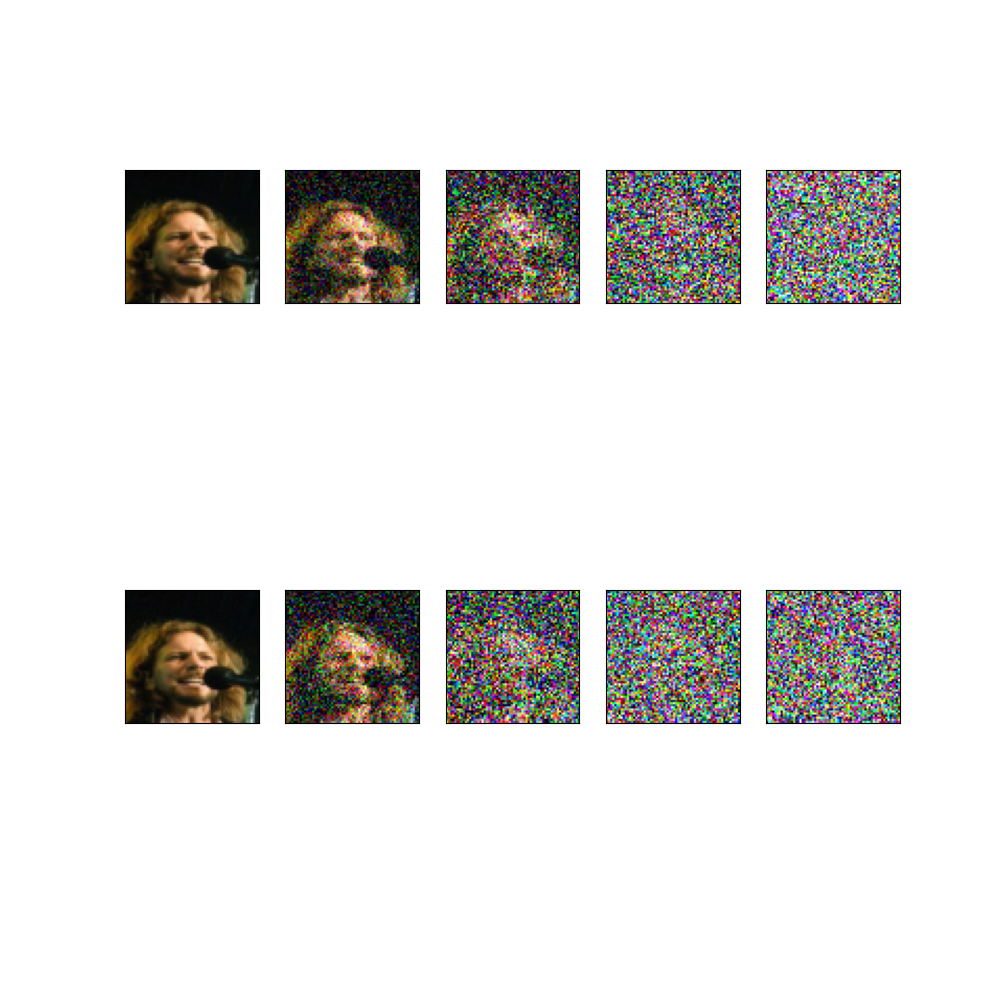

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib notebook

batch = next(iter(dataloader))

diffusion_cosin = Diffusion(
    timesteps=TIMESTEPS,
    schedular="cosine",
)

diffusion_linear = Diffusion(
    timesteps=TIMESTEPS,
    schedular="linear",
)

Xcosin, Ncosin = diffusion_process(
    x=batch["x"][0, :, :, :],
    diffusion=diffusion_cosin,
)

Xlinear, Nlinear = diffusion_process(
    x=batch["x"][0, :, :, :],
    diffusion=diffusion_linear,
)

DISPLAY_NIMAGES = 5

indicies = np.linspace(0, len(Xcosin) -1 , DISPLAY_NIMAGES, dtype=int)

fig, axs = plt.subplots(2, DISPLAY_NIMAGES, gridspec_kw={'height_ratios': [1, 2]}, figsize=(10,10))

for i, process_i in enumerate([0, 200, 500, 800, 999]):
    
    x = reverse_transform(Xcosin[process_i])
    y = reverse_transform(Xlinear[process_i])

    axs[0][i].imshow(x)
    
    axs[1][i].imshow(y)
    
    axs[0][i].axes.get_xaxis().set_visible(False)
    axs[0][i].axes.get_yaxis().set_visible(False)

    axs[1][i].axes.get_xaxis().set_visible(False)
    axs[1][i].axes.get_yaxis().set_visible(False)

<IPython.core.display.Javascript object>


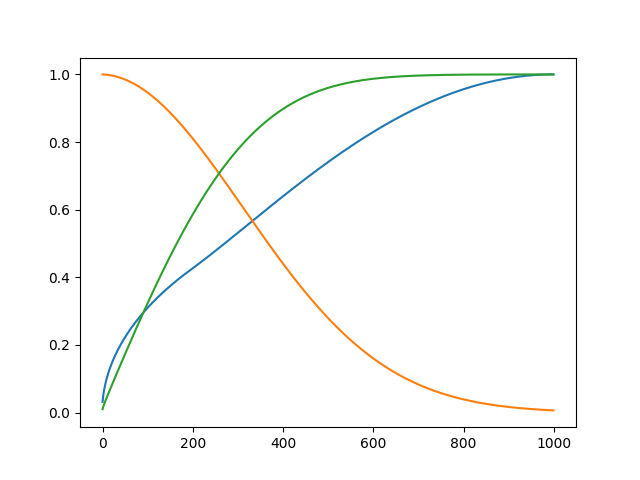

In [108]:
diffusion_cosin = Diffusion(
    timesteps=1000,
    schedular="cosine",
)

plt.plot(diffusion_cosin._sqrt_one_minus_alphas_cumprod.numpy())

diffusion_cosin = Diffusion(
    timesteps=TIMESTEPS,
    schedular="cosine",
)

plt.plot(diffusion_linear._sqrt_one_minus_alphas_cumprod.numpy())

# Train..

In [4]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

diffusion = Diffusion(
    timesteps=TIMESTEPS,
    schedular="linear",
)

from unet import UnetConditional, Unet

model = Unet(
    channels=[64, 256, 512, 1024],
    in_channels=CHANNELS,
    resnet_block_groups=8,
    use_convnext=False,
    convnext_mult=2,
    init_channel_mult=32,
    # nclasses=10,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#for p in model.parameters():
#    p.register_hook(lambda grad: torch.clamp(grad, -0.2, 0.2))

iteration = 0
image_saves = 0

In [5]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

119906627

In [ ]:
EXPERIMENT_NAME = "celeba_v2_small"

In [ ]:
writer = SummaryWriter(f"runs/{EXPERIMENT_NAME}")

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

for e in range(500):

    for step, batch in enumerate(dataloader):

        iteration += 1

        x = batch["x"].to(device)
        
        max_t = np.min([int(50 + e ** 1.1), TIMESTEPS])
        
        time = None # torch.randint(0, max_t, (x.shape[0],), device=x.device).long()
        
        x_noised, noise, time = diffusion.forward(x, time)
        
        noise_predicted = model.forward(
            x=x_noised.to(device),
            time=time.to(device),
            #classes=l.to(device),
        )

        loss = diffusion.loss(noise, noise_predicted)
        
        model.zero_grad()
        loss.backward()
        
        # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=2, norm_type=2)

        optimizer.step()
        
        writer.add_scalar("loss", loss, iteration)
        
        if iteration % 500 == 0:
            
            y = plot_process_backward(
                model=model,
                diffusion=diffusion,
                timesteps=TIMESTEPS,
                shape=[1, CHANNELS, UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE],
                device=device,
                klass=1,
            )
        
            writer.add_image(f'images',np.asarray(reverse_transform(y[-1, :, :, :])), image_saves, dataformats='HWC')
            image_saves += 1
            
            model.save(folder="ckp/small_celebA", name="best.ckp")
 
    print(e)

# Inference

In [ ]:
import matplotlib.pyplot as plt


In [261]:
diffusion = Diffusion(
    timesteps=TIMESTEPS,
    schedular="linear",
)

from unet import Unet

model = Unet(
    channels=[64, 256, 512, 1024],
    in_channels=CHANNELS,
    resnet_block_groups=8,
    use_convnext=False,
    convnext_mult=2,
    init_channel_mult=32,
)

model.load(folder="ckp/small_celebA", name="best.ckp")

_ = model.to("cuda")

In [329]:
timestep = 300 
xx = batch["x"].to(device)[40, :, :, :]

x_noised, noise, time = diffusion.forward(xx, torch.Tensor([timestep]).long().to(device))

with torch.no_grad():

    timesteps_iter = list(np.linspace(0, timestep,  timestep + 1))
    timesteps_iter.reverse()

    Y = [x_noised]

    for t in timesteps_iter:

        t = torch.Tensor([t]).long().to(device)

        predicted_noise = model.forward(
            x_noised,
            t,
        )

        x_noised = diffusion.backward(x_noised, predicted_noise, t)

        Y.append(x_noised[0, :, :, :])
        
Y = torch.stack(Y)

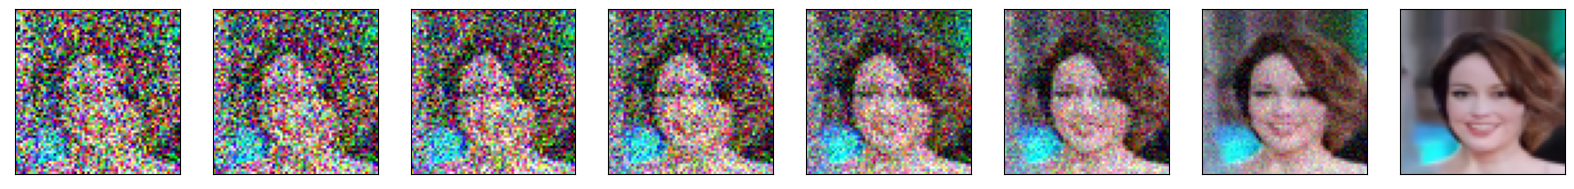

In [330]:
indicies = np.linspace(0, Y.shape[0] -1 , 8, dtype=int)
fig, axs = plt.subplots(1, len(indicies), figsize=(20, 20))

for i, process_i in enumerate(indicies):
    y = reverse_transform(Y[process_i, :, :, :])
    axs[i].imshow(y)
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)

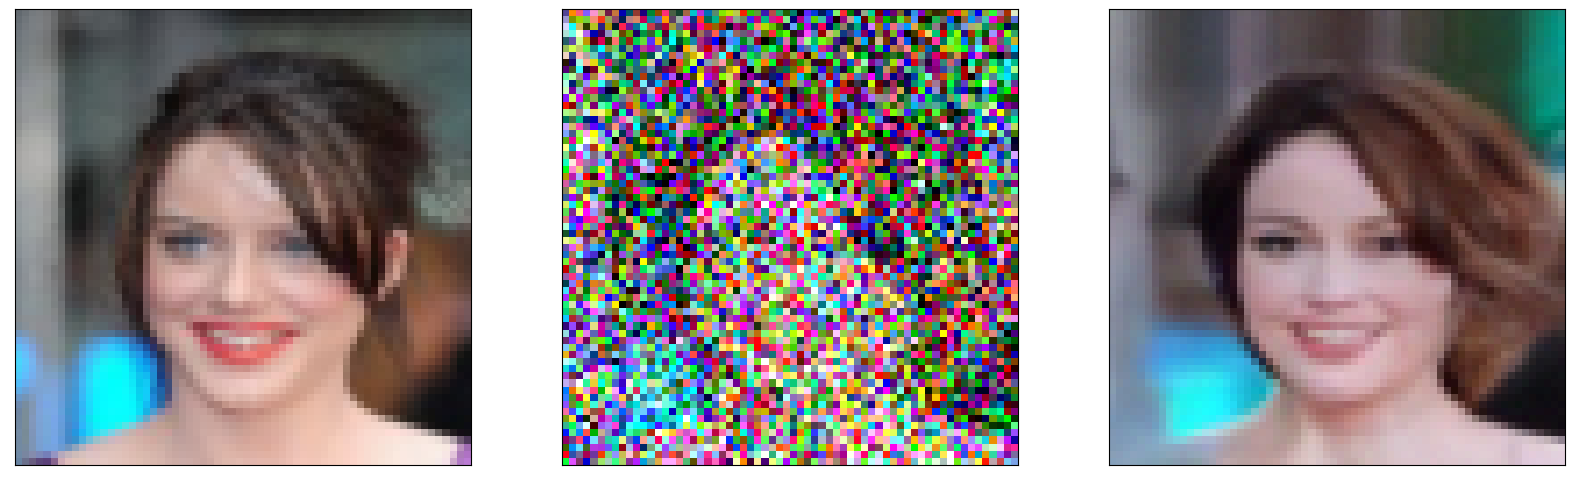

In [331]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(reverse_transform(xx))
axs[1].imshow(reverse_transform(Y[0, :, :, :]))
axs[2].imshow(reverse_transform(Y[timestep, :, :, :]))

for i in range(3):
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)